In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn import ensemble, linear_model
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, roc_curve, log_loss, plot_confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import missingno as msno
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

# Source Code

## Defining Utility Functions

In [ ]:
# Encode Categorical features
def prepare_inputs(X):
	oe = OrdinalEncoder()
	data = oe.fit_transform(X)
	return data

# Apply the ordinal encoding on categorical features
def apply_encode(data_df):
  categorical_features = data_df.select_dtypes(include=[np.object])
  data_df[categorical_features.columns] = prepare_inputs(data_df[categorical_features.columns])

  fs = SelectKBest(score_func=f_classif, k='all')
  y = data_df["install"]
  x = data_df.drop(columns=["install"])
  fs.fit(x, y)
  return data_df, fs

# Select K best numerical feature
def select_k_best_numeric_features(train_df, validate_df, numeric_features, k):
  sel_anova = SelectKBest(f_classif, k)    # select 4 features

  numeric_features.drop(columns="install", inplace=True)

  y_train = train_df["install"]
  X_train = train_df[numeric_features.columns]

  sel_anova.fit_transform(X_train, y_train)

  f_classif_selected = sel_anova.get_support()
  f_classif_selected_features = [ f for i,f in enumerate(X_train.columns) if f_classif_selected[i]]
  print('F_classif selected {} features {}.'.format(f_classif_selected.sum(),
    f_classif_selected_features))

  return train_df, validate_df  

# plot the feature importance score
def show(fs, data_df):
  cols = data_df.columns
  for i in range(len(fs.scores_)):
    print("Feature : ", cols.to_list()[i], ",", fs.scores_[i])
  # plot the scores
  plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
  plt.show()  

# print feature importance score
def feature_importance(threshold, data_df):
  cols = data_df.columns
  for i in range(len(fs.scores_)):
    if fs.scores_[i] > threshold:
      print("Feature : ", cols.to_list()[i], ",", fs.scores_[i])

# Split the data to train and test set
def split_train_test(data_df):
  X = data_df.drop('install', axis=1)
  y = data_df['install']

  original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(X, y, test_size=0.33, random_state=42)

  # Check the Distribution of the labels for train and validation datasets
  target_train_count = original_ytrain.value_counts()
  target_test_count = original_ytest.value_counts()

  print('Class 0:', round(target_train_count[0]/len(original_ytrain) * 100, 2), '% of the dataset')
  print('Class 1:', round(target_train_count[1]/len(original_ytrain) * 100, 2), '% of the dataset')

  print('Class 0:', round(target_test_count[0]/len(original_ytest) * 100, 2), '% of the dataset')
  print('Class 1:', round(target_test_count[1]/len(original_ytest) * 100, 2), '% of the dataset')

  train_df = pd.concat([original_Xtrain, original_ytrain], axis=1)
  validate_df = pd.concat([original_Xtest, original_ytest], axis=1)
  return train_df, validate_df      


# Calculate IQR for outlier removal
def computer_IQR(train_df, cats=None):
  if cats is not None:
    sub_num_features = cats
  else:
    sub_num_features = train_df.select_dtypes(include=[np.number]).drop(columns=["install"])
  Q1 = train_df[sub_num_features.columns].quantile(0.25)
  Q3 = train_df[sub_num_features.columns].quantile(0.75)
  IQR = Q3 - Q1

  print("Lower Outliers")
  print((train_df[sub_num_features.columns] < (Q1 - 1.5 * IQR)).sum(),"\n")

  print("Upper Outliers")
  print((train_df[sub_num_features.columns] > (Q3 + 1.5 * IQR)).sum(),"\n")

  return IQR, Q1, Q3

# Remove outliers based on the IQR
def remove_outlier(train_df, IQR, Q1, Q3, cats=None):
  if cats is not None:
    sub_num_features = cats
  else:
    sub_num_features = train_df.select_dtypes(include=[np.number]).drop(columns=["install"])
  print(train_df.install.value_counts()/train_df.shape[0] * 100)
  train_df = train_df[~(train_df[sub_num_features.columns] > (Q3 + 1.5 * IQR)).any(axis=1)]
  print(train_df.install.value_counts()/train_df.shape[0] * 100)
  return train_df  

# scale dataset to be between 0-1
def scale_dataset(train_df, validate_df):
  #min_max_scaler = preprocessing.RobustScaler()
  min_max_scaler = preprocessing.MinMaxScaler()
  label = train_df["install"]
  train_df.drop(columns=["install"], inplace=True)
  cols = train_df.columns
  train_df = min_max_scaler.fit_transform(train_df)
  train_df = pd.DataFrame(train_df, columns=cols)
  label = pd.DataFrame(label, columns=["install"]).reset_index(drop=True)
  train_df = pd.concat([train_df, label], axis=1)
  
  label = validate_df["install"]
  validate_df.drop(columns=["install"], inplace=True)
  cols = validate_df.columns
  validate_df = min_max_scaler.transform(validate_df)
  validate_df = pd.DataFrame(validate_df, columns=cols)
  label = pd.DataFrame(label, columns=["install"]).reset_index(drop=True)
  validate_df = pd.concat([validate_df, label], axis=1)  
  return train_df, validate_df, min_max_scaler


def resample_data(train_df):
  # Class count
  count_class_0, count_class_1 = train_df.install.value_counts()

  # Divide by class
  df_class_0 = train_df[train_df['install'] == 0]
  df_class_1 = train_df[train_df['install'] == 1]


  #df_class_1_over = df_class_1.sample(count_class_0, replace=True)
  df_class_0_under = df_class_0.sample(count_class_1, replace=False)

  train_df = pd.concat([df_class_0_under, df_class_1], axis=0)
  train_df = shuffle(train_df)

  print('Random Sampling:')
  print(train_df.install.value_counts())

  train_df.install.value_counts().plot(kind='bar', title='Count (install)')

  return train_df

def SMOTE(train_df):
  # Using SMOTE to oversample minority class
  os = SMOTE(random_state=0, sampling_strategy=1, n_jobs=-1)

  y_train = train_df["install"]
  X_train = train_df.drop("install", axis=1)

  columns = X_train.columns

  X_train,y_train=os.fit_sample(X_train, y_train)
  X_train = pd.DataFrame(data=X_train,columns=columns )
  y_train= pd.DataFrame(data=y_train,columns=['install'])

  train_df = pd.concat([X_train, y_train], axis=1)
  return train_df

# get features and lables separated for both training and test datasets
def get_X_y_train_validate(train_df, validate_df):
  y_train = train_df["install"]
  X_train = train_df.drop("install", axis=1)
  del train_df

  y_validate = validate_df["install"]
  X_validate = validate_df.drop("install", axis=1)
  del validate_df

  return X_train, y_train, X_validate, y_validate

def regroup_infrequent_countries(data_df):
  print("Nb countries before the filtering:",len(data_df['country'].unique()))
  series = pd.value_counts(data_df['country'])
  # Regroupe any country that appeared less that 1% of the time into one generic category 
  mask = (series/series.sum() * 100).lt(1)
  data_df['country'] = np.where(data_df['country'].isin(series[mask].index),'Other',data_df['country'])
  print("Nb countries after the filtering:", len(data_df['country'].unique()))
  return data_df

def regroup_devices(data_df):
  # First, squash all similar deviceType names into same category, (i.e., iPhone1,2 or iPhone 1,3 into iPhone, etc.)
  list_devices = ["iPhone", "iPad", "iPod", "samsung", "Xiaomi", "HUAWEI", "OPPO",\
                  "LG", "motorola", "vivo", "LENOVO", "Google", "HMD", "ZTE", "OnePlus",\
                  "asus", "Sony", "Micromax", "ALCATEL", "TCL", "Meizu", "General", "Acer", "LAVA",\
                  "Yulong", "WIKO", "Vertex", "Alco", "BQ", "Hisense", "Infinix", "HTC", "TECNO", "Coolpad",\
                  "teksun","Yulong", "Vestel", "GIONEE", "Prestigio", "Haier", "LeMobile", "Amazon",\
                  "LeMobile", "Multilaser", "Quanta", "Lanix"]

  for device in list_devices:
    data_df['deviceType']=np.where(data_df["deviceType"].str.contains(device, case=False), device, data_df['deviceType'])

  # Regroupe any deviceType that appeared less that 1% of the time into one generic category
  print("Nb deviceType before the filtering:", len(data_df['deviceType'].unique()))
  series = pd.value_counts(data_df['deviceType'])
  mask = (series/series.sum() * 100).lt(1)
  data_df['deviceType'] = np.where(data_df['deviceType'].isin(series[mask].index),'Other',data_df['deviceType'])
  print("Nb deviceType after the filtering:", len(data_df['deviceType'].unique())) 
  return data_df


def one_hot_encode(data_df):
  enc = OneHotEncoder(handle_unknown= "ignore")
  transformed = enc.fit_transform(data_df).toarray()
  transformed = pd.DataFrame(transformed)
  return transformed, enc

# Useful when training a MLP build with pytorch
def return_numpy(X_train, y_train, X_validate, y_validate):
  # Tranform DataFrame to numpy array:
  X_train = X_train.to_numpy()
  y_train = np.expand_dims(y_train, axis=1)

  X_validate = X_validate.to_numpy()
  y_validate = np.expand_dims(y_validate, axis=1)

  return X_train, y_train, X_validate, y_validate   

##Metrics APIs

In [ ]:
def roc_cal(X_validate, y_validate, model, text, isDNN):
  # predict probabilities
  if isDNN:    
    y_pred = model(X_validate)
    y_pred = np.array(np.round(torch.Tensor.cpu(y_pred.detach())))
    y_validate = np.array(np.round(torch.Tensor.cpu(y_validate.detach())))
  else:
    y_pred = model.predict_proba(X_validate)
  # keep probabilities for the positive outcome only
  if not isDNN:
    y_pred = y_pred[::, 1]
  # calculate scores
  ns_probs = [0 for _ in range(len(y_validate))]
  ns_auc = roc_auc_score(y_validate, ns_probs)
  lr_auc = roc_auc_score(y_validate, y_pred)
  # summarize scores
  print('Random: ROC AUC=%.3f' % (ns_auc))
  print(text, ': ROC AUC=%.3f' % (lr_auc))
  # calculate roc curves
  ns_fpr, ns_tpr, _ = roc_curve(y_validate, ns_probs)
  lr_fpr, lr_tpr, _ = roc_curve(y_validate, y_pred)
  # plot the roc curve for the model
  plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Random')
  plt.plot(lr_fpr, lr_tpr, marker='.', label=text)
  # axis labels
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  # show the legend
  plt.legend()
  # show the plot
  plt.show()

In [ ]:
def log_loss_print(X_validate, y_validate, model, text, isDNN):
  if isDNN:    
    y_pred = model(X_validate)
    y_pred = np.array(np.round(torch.Tensor.cpu(y_pred.detach())))
    y_validate = np.array(np.round(torch.Tensor.cpu(y_validate.detach())))  
  else:
    y_pred = model.predict_proba(X_validate)
    y_pred = y_pred[:, 1]
  # keep probabilities for the positive outcome only
  print(text, ': Log Loss=%.3f' % (log_loss(y_validate, y_pred)))

In [ ]:
def conf_matrix(X_validate, y_validate, model, isDNN):
  if isDNN:    
    y_pred = model(X_validate)
    y_pred = np.array(np.round(torch.Tensor.cpu(y_pred.detach())))
    y_validate = np.array(np.round(torch.Tensor.cpu(y_validate.detach())))  
  else:
    y_pred = model.predict(X_validate)
    y_pred = np.array(np.round(y_pred))
  conf_mat = confusion_matrix(y_validate, y_pred, normalize="true")

  labels = ['Class 0', 'Class 1']
  fig = plt.figure()
  ax = fig.add_subplot(111)
  ax.matshow(conf_mat, cmap=plt.cm.Blues)
  for (i, j), z in np.ndenumerate(conf_mat):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center', fontsize=20, color='red')
  ax.set_xticklabels([''] + labels)
  ax.set_yticklabels([''] + labels)
  plt.xlabel('Predicted')
  plt.ylabel('Expected')
  plt.show()  

In [ ]:
def perf_mertics(X, y, model, text, isDNN = False):
  roc_cal(X, y, model, text, isDNN)
  log_loss_print(X, y, model, text, isDNN)
  conf_matrix(X, y, model, isDNN)

## Training Models Code:

In [ ]:
# Random Forest Model
def RF(X_train, y_train, X_validate, y_validate, estimators, features, depth, oob_score_):
  rf = RandomForestClassifier(n_estimators = estimators, #nb of trees in the forest
                              n_jobs = -1,
                              max_features = features,
                              max_depth = depth,
                              oob_score = oob_score_, # use out-of-bag to estimate accuracy
                              random_state = 42)
  rf.fit(X_train, y_train.ravel())

  print('R^2 Training Score: {:.2f} \nR^2 Validation Score: {:.2f}'.format(rf.score(X_train, y_train.ravel()),
                                                                          rf.score(X_validate, y_validate.ravel())))
  
  print('\033[94m', "Training Performance", '\033[0m')
  perf_mertics(X_train, y_train, rf, "RF", False)
  print('\033[94m', "Validation Performance", '\033[0m')
  perf_mertics(X_validate, y_validate, rf, "RF", False)

  return rf

# Logistic Regression Model
def lr(X_train, y_train, X_validate, y_validate):

  model_lr = LogisticRegression()
  model_lr.fit(X_train, y_train)

  print('R^2 Training Score: {:.2f} \nR^2 Validation Score: {:.2f}'.format(model_lr.score(X_train, y_train),
                                                                           model_lr.score(X_validate, y_validate)))


  print('\033[94m', "Validation Performance", '\033[0m')
  perf_mertics(X_validate, y_validate, model_lr, "Logistic Regression", False)

  return model_lr

# Building the MLP
class MLP(torch.nn.Module):
  def __init__(self, D_in, H, D_out):
      super(MLP, self).__init__()
      self.input_linear = torch.nn.Linear(D_in, H)
      self.middle_linear = torch.nn.Linear(H, H)
      self.output_linear = torch.nn.Linear(H, D_out)        
      self.bn1 = nn.BatchNorm1d(H)
      self.bn2 = nn.BatchNorm1d(H)

  def forward(self, x):
      h_relu = F.relu(self.bn1(self.input_linear(x)))
      h_relu = F.relu(self.bn2(self.middle_linear(h_relu)))
      y_pred = torch.sigmoid(self.output_linear(h_relu))
      return y_pred

## applies the specified weight initialization
def weights_init_normal(m):
    '''Takes in a module and initializes all linear layers with weight
        values taken from a normal distribution.'''
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        y = m.in_features
        m.weight.data.normal_(0.0,0.1)
        m.bias.data.fill_(0)

In [ ]:
def train_mlp(X_train, y_train, X_validate, y_validate, model, num_epochs=100, lr_=1e-3):
  criterion = nn.BCELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=lr_)

  device = 'cuda' if torch.cuda.is_available() else 'cpu'

  x_valid = torch.from_numpy(X_validate).float()
  y_valid = torch.from_numpy(y_validate).float()

  x = torch.from_numpy(X_train).float()
  y = torch.from_numpy(y_train).float()

  train_data = TensorDataset(x, y)

  train_loader = DataLoader(dataset=train_data, batch_size=128, shuffle=True)
  model.train()

  best_model_state_dict, best_valid_loss = None, float("inf")
  
  for epoch in range(num_epochs):
    losses = []
    counter = 0  
    for x_batch, y_batch in train_loader: 
      counter += 1
      x_batch = x_batch.to(device)
      y_batch = y_batch.to(device)   
          
      y_pred = model(x_batch)
      # Compute and print loss
      loss_train = criterion(y_pred, y_batch)
      losses.append(loss_train.data)

      # Zero gradients, perform a backward pass, and update the weights.
      optimizer.zero_grad()
      loss_train.backward()
      optimizer.step()
    
    # Validation loss
    model.eval()
    with torch.no_grad():
      out = model(x_valid.to(device))

    model.train()
    loss_valid = criterion(out, y_valid.to(device))

    # Pick the best model wrt the validation loss
    if loss_valid.data < best_valid_loss:
      best_model_state_dict = model.state_dict()
      best_valid_loss = loss_valid.data

    if (epoch) % 10 == 0:
      print('Epoch [%d/%d] Train Loss: %.4f, Valid Loss: %.4f' %(epoch + 1, num_epochs, sum(losses)/len(losses), loss_valid.data))

  # PREDICTIONS
  model.load_state_dict(best_model_state_dict)
  model.eval()
  y_pred = model(x)
  pred = np.round(torch.Tensor.cpu(y_pred.detach()))
  target = np.round(torch.Tensor.cpu(y.detach()))
  y_prediction = y_pred.tolist()
  y_true = target.tolist()

  print("Accuracy on training set is", accuracy_score(np.array(y_true),np.array(y_prediction).round()))
  print("ROC AUC on training set is", roc_auc_score(np.array(y_true), np.array(y_prediction).round()))      


  print('\033[94m', "Training Performance", '\033[0m')
  perf_mertics(x, y, model, "DNN Train", True)
  
  print('\033[94m', "Validation Performance", '\033[0m')
  perf_mertics(x_valid, y_valid, model, "DNN Validate", True)

  return model

In this Notebook, I present my work to try to predict the install probability of an impression. The dataset contains ~2million data point and 16 feature, and one lable.

The challenges that I faced during the task:


1.   Some missing data that I tried to fill with my best knowledge of the problem
2.   Some features are ID (campaignID or sourceGameID) that have huge number of unique values.
3.   Many outliers for some numerical data
4.   Some numerical features are noisy
5.   The dataset is highly imbalanced

In the following work, I will first explore the data


# Read data in chunks:


In [ ]:
chunks = pd.read_csv('training_data.csv', chunksize=1000000, sep=';')
data_df = pd.concat(chunks)

Look at some data samples:

In [ ]:
data_df.head()

,id,timestamp,campaignId,platform,softwareVersion,sourceGameId,country,startCount,viewCount,clickCount,installCount,lastStart,startCount1d,startCount7d,connectionType,deviceType,install
0,5c36658fb58fad351175f0b6,2019-01-09T21:20:15.943+00:00,59687f0d896a6b0e5ce6ea15,ios,11.4.1,1373094,US,25,24,0,2,2019-01-08T18:49:48.129+00:00,1,8,cellular,"iPhone8,2",0
1,5c38d5ab1c16172870186b5a,2019-01-11T17:43:07.609+00:00,59687f0d896a6b0e5ce6ea15,ios,12.1,2739989,US,10,9,2,0,2019-01-09T21:20:22.855+00:00,1,4,cellular,"iPhone9,1",0
2,5c38815de8f4e50e256e4f9c,2019-01-11T11:43:25.168+00:00,59687f0d896a6b0e5ce6ea15,ios,12.1.2,1373094,US,27,26,0,0,2019-01-09T10:42:08.446+00:00,1,2,cellular,"iPhone7,1",0
3,5c409ace532d5806d2c6a5e6,2019-01-17T15:10:06.420+00:00,59687f0d896a6b0e5ce6ea15,ios,12.1.2,1217749,US,15,14,2,0,2019-01-16T19:58:11.636+00:00,3,14,wifi,"iPhone7,2",0
4,5c3904b92d798c41e7f3088a,2019-01-11T21:03:53.145+00:00,59687f0d896a6b0e5ce6ea15,ios,12.0.1,1373094,US,20,18,0,0,2019-01-11T21:03:05.103+00:00,13,18,cellular,"iPhone8,1",0


**Look at the data dimensions (how many data points and how many features)**

In [ ]:
print("Shape:", data_df.shape)

Shape: (2206990, 17)


In [ ]:
data_df.describe()

,sourceGameId,startCount,viewCount,clickCount,installCount,startCount1d,startCount7d,install
count,2.206990e+06,2.206990e+06,2.206990e+06,2.206990e+06,2.206990e+06,2.206990e+06,2.206990e+06,2.206990e+06
mean,3.085592e+06,4.831307e+01,3.595887e+01,2.099431e+00,5.703424e-01,6.787689e+00,1.978492e+01,1.200594e-02
std,1.376251e+07,9.039421e+01,7.899328e+01,6.797011e+00,1.543641e+00,1.136146e+01,3.468965e+01,1.089119e-01
min,1.105500e+04,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
25%,1.202538e+06,6.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,3.000000e+00,0.000000e+00
50%,1.631784e+06,1.900000e+01,1.000000e+01,0.000000e+00,0.000000e+00,3.000000e+00,9.000000e+00,0.000000e+00
75%,2.639966e+06,5.300000e+01,3.400000e+01,2.000000e+00,1.000000e+00,8.000000e+00,2.300000e+01,0.000000e+00
max,1.316274e+08,3.997000e+03,2.886000e+03,1.031000e+03,7.300000e+01,1.466000e+03,3.280000e+03,1.000000e+00


# Exploratory Data Analysis

In [ ]:
data_df.groupby("install").mean()

,sourceGameId,startCount,viewCount,clickCount,installCount,startCount1d,startCount7d
install,,,,,,,
0,3.088983e+06,48.559665,36.152471,2.101611,0.566033,6.806974,19.874745
1,2.806593e+06,28.020115,20.027211,1.920104,0.925010,5.200702,12.392837


**Observations**:

1.   Surprisingly, the mean startCount, viewCount and startCount7d are higher when no install was observed
2.   the mean of clickCount doesn't seem to vary a lot for both cases





In case there are duplicates, remove them:

In [ ]:
duplicateRow = data_df[data_df.duplicated(keep=False)]
print(len(duplicateRow))

0


**List the numerical features in the train dataset:**


In [ ]:
numeric_features = data_df.select_dtypes(include=[np.number])
numeric_features.columns

Index(['sourceGameId', 'startCount', 'viewCount', 'clickCount', 'installCount',
       'startCount1d', 'startCount7d', 'install'],
      dtype='object')

**List the categorical features in the train dataset:**

In [ ]:
categorical_features = data_df.select_dtypes(include=[np.object])
categorical_features.columns

Index(['id', 'timestamp', 'campaignId', 'platform', 'softwareVersion',
       'country', 'lastStart', 'connectionType', 'deviceType'],
      dtype='object')

**Do we have discrete numerical features:**

In [ ]:
discrete_feature=[feature for feature in numeric_features if len(data_df[feature].unique())<30 and feature != "install"]
print("Discrete Variables Count: {}".format(len(discrete_feature)))

Discrete Variables Count: 0


## Numerical features distribution for both classes (1 and 0 respectively)

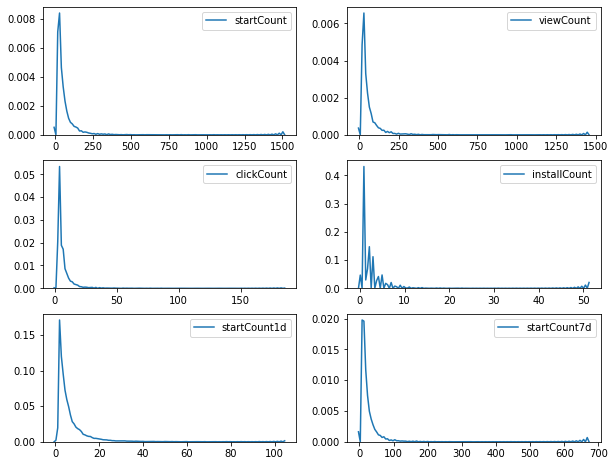

In [ ]:
# plot original distribution plot
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(ncols=2, nrows=3, figsize=(10, 8))
sns.kdeplot(data_df["startCount"].loc[data_df['install'] == 1], ax=ax1)
sns.kdeplot(data_df["viewCount"].loc[data_df['install'] == 1], ax=ax2)
sns.kdeplot(data_df["clickCount"].loc[data_df['install'] == 1], ax=ax3)
sns.kdeplot(data_df["installCount"].loc[data_df['install'] == 1], ax=ax4)
sns.kdeplot(data_df["startCount1d"].loc[data_df['install'] == 1], ax=ax5)
sns.kdeplot(data_df["startCount7d"].loc[data_df['install'] == 1], ax=ax6)

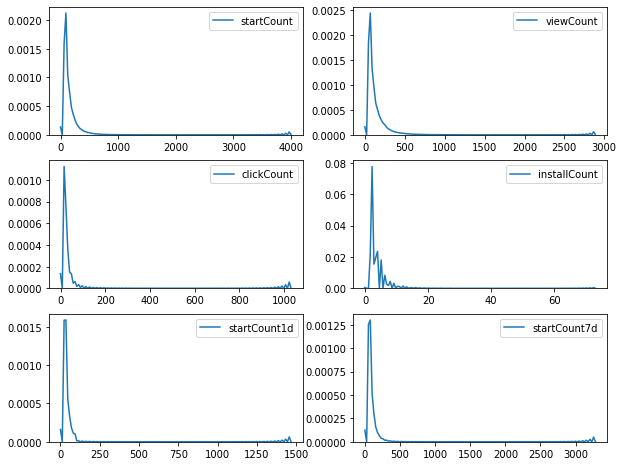

In [ ]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(ncols=2, nrows=3, figsize=(10, 8))
sns.kdeplot(data_df["startCount"].loc[data_df['install'] == 0], ax=ax1)
sns.kdeplot(data_df["viewCount"].loc[data_df['install'] == 0], ax=ax2)
sns.kdeplot(data_df["clickCount"].loc[data_df['install'] == 0], ax=ax3)
sns.kdeplot(data_df["installCount"].loc[data_df['install'] == 0], ax=ax4)
sns.kdeplot(data_df["startCount1d"].loc[data_df['install'] == 0], ax=ax5)
sns.kdeplot(data_df["startCount7d"].loc[data_df['install'] == 0], ax=ax6)

Data is noisy, specially for installCount. Some outliers also may have an impact on the shape of the distribution that is so spread over extrem values. I wil filter the outliers later.



## Handling datetime features on the whole dataset


First, transform the string to datetime type

In [ ]:
data_df["timestamp_dt"] = pd.to_datetime(data_df["timestamp"], format = "%Y-%m-%dT%H:%M:%S", errors = "coerce")
data_df["lastStart_dt"] = pd.to_datetime(data_df["lastStart"], format = "%Y-%m-%dT%H:%M:%S", errors = "coerce")

data_df.drop(columns=["timestamp", "lastStart"], inplace=True)

**Some of the lastStart_dt data are missing:**

,Total,Percent
lastStart_dt,163180,0.073938
country,101,0.000046
viewCount,0,0.000000
campaignId,0,0.000000
platform,0,0.000000


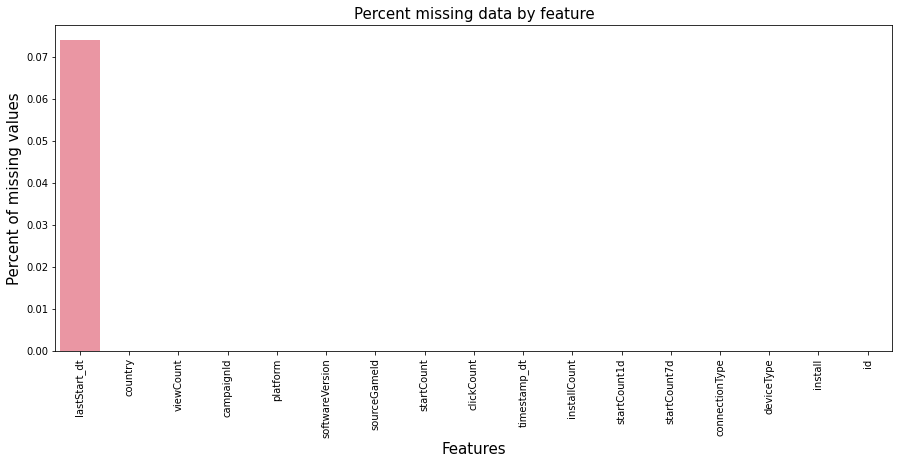

In [ ]:
total = data_df.isnull().sum().sort_values(ascending=False)
percent = (data_df.isnull().sum()/data_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
f, ax = plt.subplots(figsize=(15, 6))
plt.xticks(rotation='90')
sns.barplot(x=missing_data.index, y=missing_data['Percent'])
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)
missing_data.head()

I noticed this property, which I should respect when dealing with missing data for lastStart_dt

In [ ]:
(data_df['lastStart_dt'] >= data_df['timestamp_dt']).sum()

0

Decompose the datetime features to a set of features (Day, Month, Year, etc.). That makes it easier to manipulate them and use them for prediction purposes

In [ ]:
data_df["Event_Year"] = data_df["timestamp_dt"].dt.year
data_df["Event_Month"] = data_df["timestamp_dt"].dt.month
data_df["Event_Day"] = data_df["timestamp_dt"].dt.day
data_df["Event_Hour"] = data_df["timestamp_dt"].dt.hour
data_df["Event_Minute"] = data_df["timestamp_dt"].dt.minute
data_df["Event_Dayofweek"] = data_df["timestamp_dt"].dt.dayofweek

data_df["LastStart_Year"] = data_df["lastStart_dt"].dt.year
data_df["LastStart_Month"] = data_df["lastStart_dt"].dt.month
data_df["LastStart_Day"] = data_df["lastStart_dt"].dt.day
data_df["LastStart_Hour"] = data_df["lastStart_dt"].dt.hour
data_df["LastStart_Minute"] = data_df["lastStart_dt"].dt.minute
data_df["LastStart_Dayofweek"] = data_df["lastStart_dt"].dt.dayofweek

data_df.drop(columns=["timestamp_dt", "lastStart_dt"], inplace=True)

data_df.head()

,id,campaignId,platform,softwareVersion,sourceGameId,country,startCount,viewCount,clickCount,installCount,startCount1d,startCount7d,connectionType,deviceType,install,Event_Year,Event_Month,Event_Day,Event_Hour,Event_Minute,Event_Dayofweek,LastStart_Year,LastStart_Month,LastStart_Day,LastStart_Hour,LastStart_Minute,LastStart_Dayofweek
0,5c36658fb58fad351175f0b6,59687f0d896a6b0e5ce6ea15,ios,11.4.1,1373094,US,25,24,0,2,1,8,cellular,"iPhone8,2",0,2019,1,9,21,20,2,2019.0,1.0,8.0,18.0,49.0,1.0
1,5c38d5ab1c16172870186b5a,59687f0d896a6b0e5ce6ea15,ios,12.1,2739989,US,10,9,2,0,1,4,cellular,"iPhone9,1",0,2019,1,11,17,43,4,2019.0,1.0,9.0,21.0,20.0,2.0
2,5c38815de8f4e50e256e4f9c,59687f0d896a6b0e5ce6ea15,ios,12.1.2,1373094,US,27,26,0,0,1,2,cellular,"iPhone7,1",0,2019,1,11,11,43,4,2019.0,1.0,9.0,10.0,42.0,2.0
3,5c409ace532d5806d2c6a5e6,59687f0d896a6b0e5ce6ea15,ios,12.1.2,1217749,US,15,14,2,0,3,14,wifi,"iPhone7,2",0,2019,1,17,15,10,3,2019.0,1.0,16.0,19.0,58.0,2.0
4,5c3904b92d798c41e7f3088a,59687f0d896a6b0e5ce6ea15,ios,12.0.1,1373094,US,20,18,0,0,13,18,cellular,"iPhone8,1",0,2019,1,11,21,3,4,2019.0,1.0,11.0,21.0,3.0,4.0


In [ ]:
print(data_df.groupby("Event_Year").size())
print(data_df.groupby("Event_Month").size())

Event_Year
2019    2206990
dtype: int64
Event_Month
1    2206990
dtype: int64


In [ ]:
print(data_df.groupby("LastStart_Year").size())
print(data_df.groupby("LastStart_Month").size())

LastStart_Year
2018.0      44544
2019.0    1999266
dtype: int64
LastStart_Month
1.0     1999266
12.0      44544
dtype: int64


It looks like the data collected for **Event_Year** and **Event_Month** were just for one year and one month of that same year. So I will not use both as features. As for **LastStart_Year** and **LastStart_Month**, we also can see that the collected data were just for limited years and months. Apparently, the data was collected during end of 2018 and beginning of 2019. I would also remove them to prevent the model to overfit over these specific years and months.


In [ ]:
data_df.drop(columns=["Event_Year", "Event_Month"], inplace=True)
data_df.drop(columns=["LastStart_Year", "LastStart_Month"], inplace=True)

## Check for missing values for the whole dataset

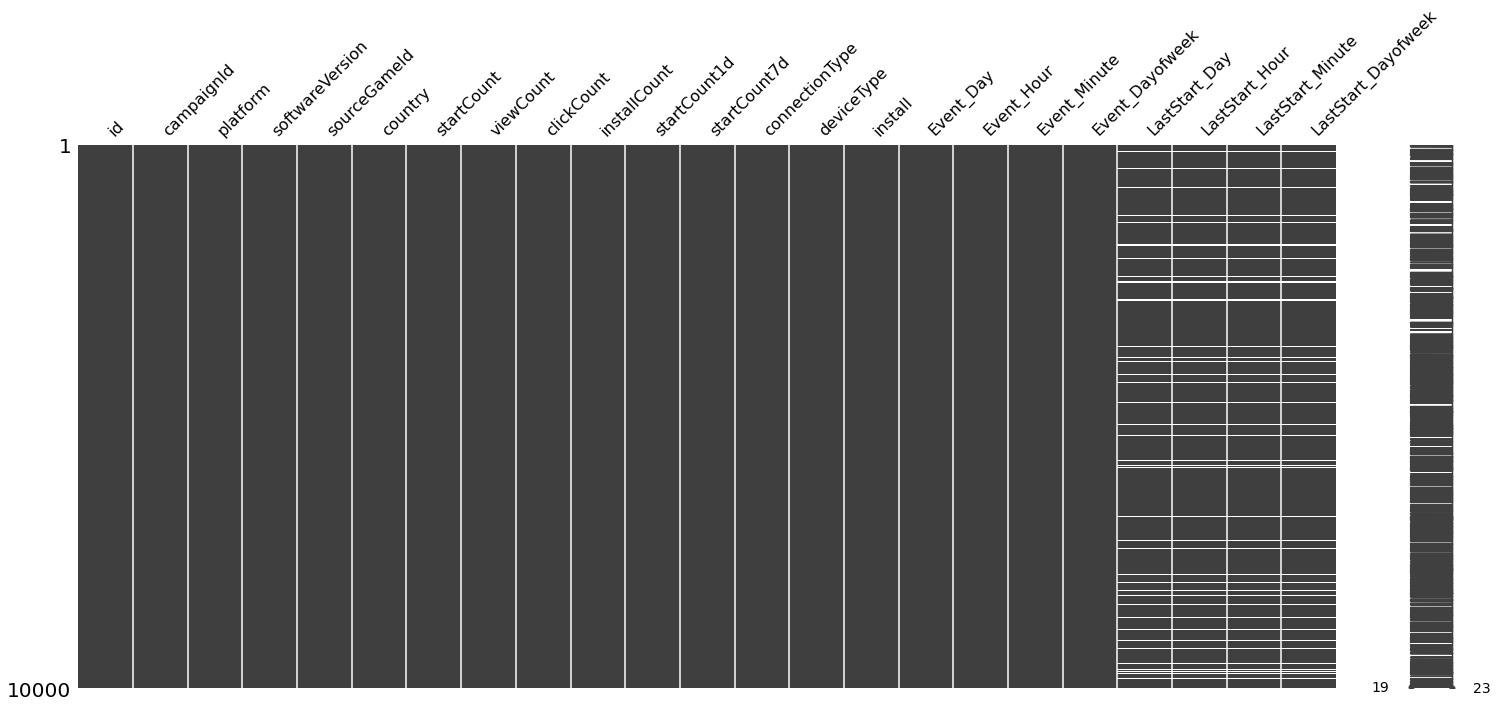

In [ ]:
msno.matrix(data_df.sample(10000))

,Total,Percent
LastStart_Dayofweek,163180,0.073938
LastStart_Hour,163180,0.073938
LastStart_Day,163180,0.073938
LastStart_Minute,163180,0.073938
country,101,0.000046


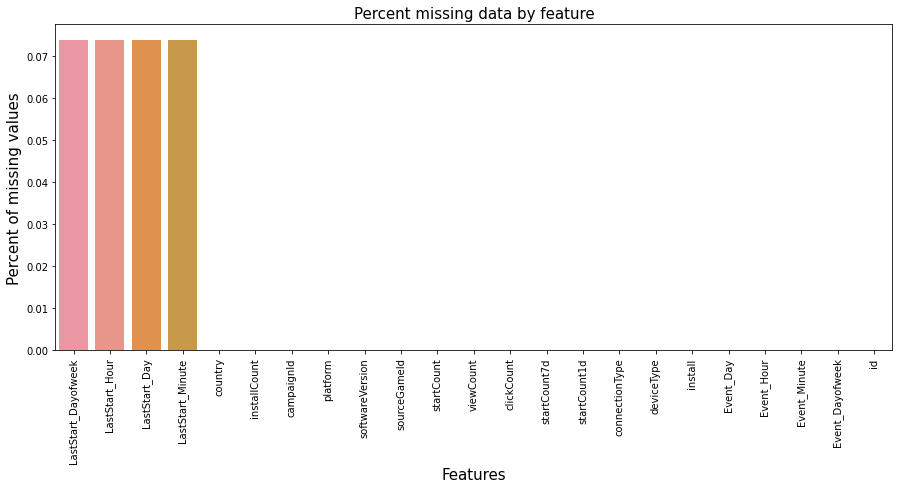

In [ ]:
total = data_df.isnull().sum().sort_values(ascending=False)
percent = (data_df.isnull().sum()/data_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
f, ax = plt.subplots(figsize=(15, 6))
plt.xticks(rotation='90')
sns.barplot(x=missing_data.index, y=missing_data['Percent'])
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)
missing_data.head()

Let us check whether the nb of rows with missing data can be removed or not. I think about removing these row as we have enough data to use for training.


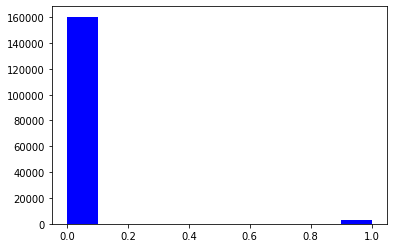

0.0735425429019951
0.10646488281692267


In [ ]:
data = data_df[data_df.LastStart_Day.isnull()]
plt.hist(data['install'],orientation = 'vertical',histtype = 'bar', color ='blue')
plt.show()

print((data.install == 0).sum() / (data_df.install == 0).sum())
print((data.install == 1).sum() / (data_df.install == 1).sum())

The percentage of rows with missing data is a bit high, so I will try to impute the missing data in these features. I chose here the min, cause I wanted to preserve the property between lastStart and timestamp. From the data, lastStart is always smaller than timestamp 

In [ ]:
data_df['LastStart_Day'].fillna(data_df['LastStart_Day'].min(), inplace=True)
data_df['LastStart_Dayofweek'].fillna(data_df['LastStart_Dayofweek'].min(), inplace=True)
data_df['LastStart_Hour'].fillna(data_df['LastStart_Hour'].min(), inplace=True)
data_df['LastStart_Minute'].fillna(data_df['LastStart_Minute'].min(), inplace=True)

Check for missing data for Country

,Total,Percent
country,101,0.000046
LastStart_Dayofweek,0,0.000000
startCount1d,0,0.000000
campaignId,0,0.000000
platform,0,0.000000


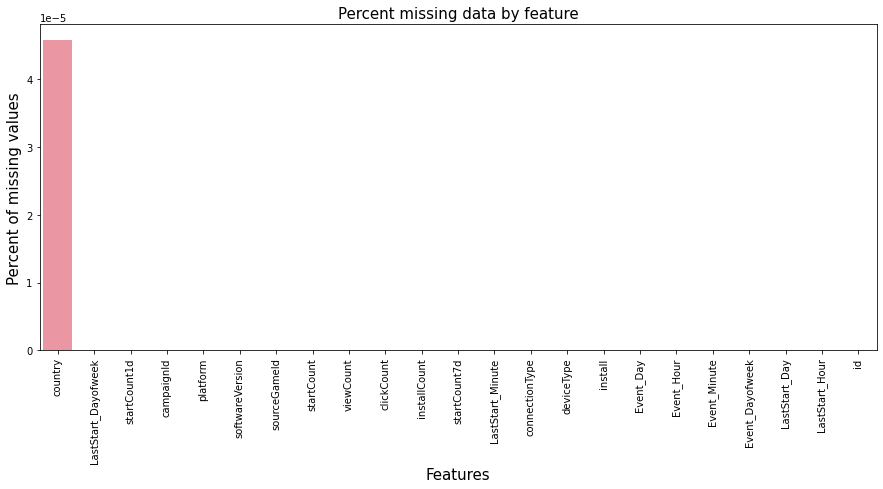

In [ ]:
total = data_df.isnull().sum().sort_values(ascending=False)
percent = (data_df.isnull().sum()/data_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
f, ax = plt.subplots(figsize=(15, 6))
plt.xticks(rotation='90')
sns.barplot(x=missing_data.index, y=missing_data['Percent'])
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)
missing_data.head()

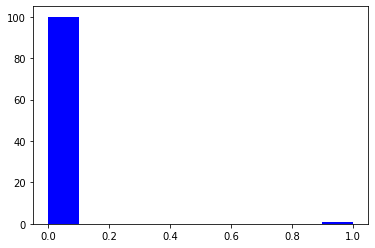

4.586118827256038e-05
3.7740121523191305e-05


In [ ]:
data = data_df[data_df.country.isnull()]
plt.hist(data['install'],orientation = 'vertical',histtype = 'bar', color ='blue')
plt.show()

print((data.install == 0).sum() / (data_df.install == 0).sum())
print((data.install == 1).sum() / (data_df.install == 1).sum())

del data

The percentage of rows with empty country is very small for both classes, but still I will keep it, cause I will hot encode this features anyway. So Nan will be a category on its own

In [ ]:
data_df['country'].fillna("Other", inplace=True)

## Check for imbalanced class distributions:



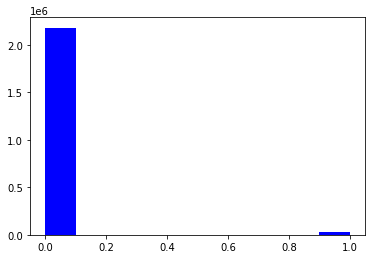

In [ ]:
plt.hist(data_df['install'],orientation = 'vertical',histtype = 'bar', color ='blue')
plt.show()

In [ ]:
target_count = data_df['install'].value_counts()

print('Class 0:', round(target_count[0]/len(data_df) * 100, 2), '% of the dataset')
print('Class 1:', round(target_count[1]/len(data_df) * 100, 2), '% of the dataset')
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

Class 0: 98.8 % of the dataset
Class 1: 1.2 % of the dataset
Proportion: 82.29 : 1


We will need to account for this class imbalance, otherwise, the model will not learn patterns for the minority class

I will pickle the original data, cause later I will try another approach for feature selection, so I will use the same dataframe after filling missing data and dealing with datetime features

In [ ]:
data_df.to_pickle("data_df_original")

#Feature Engineering

##Feature Selection

In this section, I try to score features based on their importance. First I encode categorical features. Second, I fit an ANOVA F-value for feature selection. Based on the score of this approach, I will chose the features to take into account

Feature :  id , 0.6821178926089625
Feature :  campaignId , 7.067313708804394
Feature :  platform , 7.9758784623823225
Feature :  softwareVersion , 9.386640667995055
Feature :  sourceGameId , 11.021878713465464
Feature :  country , 14.784663630063438
Feature :  startCount , 1352.4382267654864
Feature :  viewCount , 1091.4372830717525
Feature :  clickCount , 18.6681907938413
Feature :  installCount , 1416.68055803945
Feature :  startCount1d , 523.3881776287301
Feature :  startCount7d , 1218.47187151529
Feature :  connectionType , 24.889962311964084
Feature :  deviceType , 0.007577533568569996
Feature :  install , 0.5345103783973045
Feature :  Event_Day , 2.25739484459211
Feature :  Event_Hour , 1.3924681740120002
Feature :  Event_Minute , 57.401768587499106
Feature :  Event_Dayofweek , 143.6417024635383
Feature :  LastStart_Day , 107.1181180435077
Feature :  LastStart_Hour , 46.46023238382979
Feature :  LastStart_Minute , 4.31054176914438


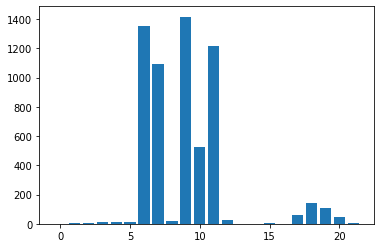

In [ ]:
tmp_df, fs = apply_encode(data_df)
show(fs, tmp_df)

From this plot, we can deduce that many features can be discarded, because they do not contribute much in the prediction of the target. These features to discard based on a threshold > 50

In [ ]:
feature_importance(40, data_df)

Feature :  startCount , 1352.4382267654864
Feature :  viewCount , 1091.4372830717525
Feature :  installCount , 1416.68055803945
Feature :  startCount1d , 523.3881776287301
Feature :  startCount7d , 1218.47187151529
Feature :  Event_Minute , 57.401768587499106
Feature :  Event_Dayofweek , 143.6417024635383
Feature :  LastStart_Day , 107.1181180435077
Feature :  LastStart_Hour , 46.46023238382979


In [ ]:
data_df = data_df[["startCount", "viewCount", "installCount", "startCount1d","startCount7d", \
                   "Event_Minute", "Event_Dayofweek", "LastStart_Day", "LastStart_Hour", "install"]]

## Split the data into train and validation while preserving the class distribution in both datasets

In [ ]:
train_df, validate_df = split_train_test(data_df)

Class 0: 98.8 % of the dataset
Class 1: 1.2 % of the dataset
Class 0: 98.79 % of the dataset
Class 1: 1.21 % of the dataset


##Removing outliers for numerical features based on IQR Score

I will use the IQR score technique to get rid of some outliers

In [ ]:
IQR, Q1, Q3 = computer_IQR(train_df)

Lower Outliers
startCount         0
viewCount          0
installCount       0
startCount1d       0
startCount7d       0
Event_Minute       0
Event_Dayofweek    0
LastStart_Day      0
LastStart_Hour     0
dtype: int64 

Upper Outliers
startCount         146192
viewCount          170252
installCount        94716
startCount1d       121050
startCount7d       126778
Event_Minute            0
Event_Dayofweek         0
LastStart_Day        6742
LastStart_Hour          0
dtype: int64 



Remove outliers and check the class ratio before and after the removal of outliers, in order to make sure that we didn't change to much the data

In [ ]:
train_df = remove_outlier(train_df, IQR, Q1, Q3)

0    98.802245
1     1.197755
Name: install, dtype: float64
0    98.733008
1     1.266992
Name: install, dtype: float64


##Scaling training and validation datasets

Here I scale numerical features to be between 0-1. I fit a Scaler on the training set, and use it to scale the validation set. This same scale will be used afterwards to scale the test dataset

In [ ]:
train_df, validate_df, min_max_scaler_1 = scale_dataset(train_df, validate_df)

## Resampling to balance the train dataset


I am only presenting the undersampling approach here. But I have tried to use SMOTE to oversample the minority class, but it gave me worse performance than what I am getting now.

Random Sampling:
0.0    14406
1.0    14406
Name: install, dtype: int64


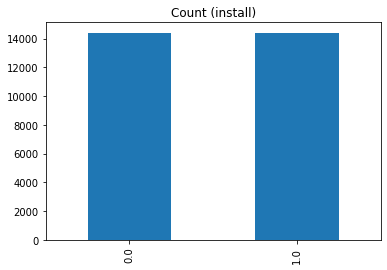

In [ ]:
train_df = resample_data(train_df)

This is just to get features and lables separated for both training and test datasets


In [ ]:
X_train, y_train, X_validate, y_validate = get_X_y_train_validate(train_df, validate_df)

# Modelling approach

The problem we are facing is clearly a binary classification problem, where we need to classify an impression's label as 1 or 0. I chose to try three diff approaches and compare between their performance.

The three approaches are:
1. Random Forest Classifier
2. Logistic Regrression
3. Multilayer perceptron with binary cross entropy loss function

And the metrics used are:


1.   ROC AUC
2.   Log Loss
3.   Confusion matrix



# Training a RF model

The Random Forest with the default hyperparameters value has this performance on the validation set:


1.   ROC-AUC = 0.589
2.   Log Loss = 0.732
3.   Confustion Matric as shown below

This is a bad performance due to overfitting, as shown in the ROC on the training dataset.



R^2 Training Score: 0.96 
R^2 Validation Score: 0.59
 Training Performance 
Random: ROC AUC=0.500
RF : ROC AUC=0.994


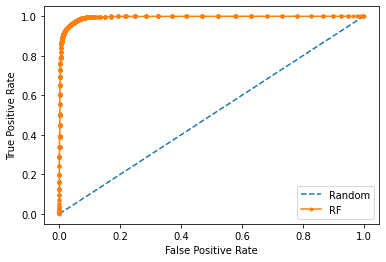

RF : Log Loss=0.243


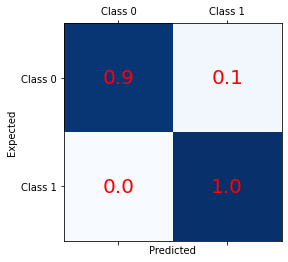

 Validation Performance 
Random: ROC AUC=0.500
RF : ROC AUC=0.586


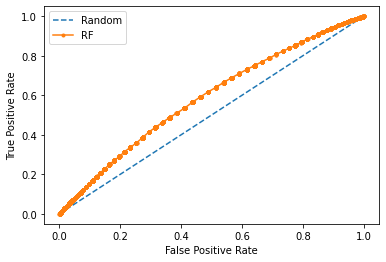

RF : Log Loss=0.718


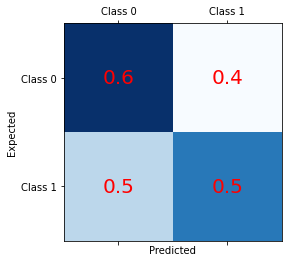

In [ ]:
model_rf_1 = RF(X_train, y_train, X_validate, y_validate, estimators=100, features="auto", depth=None, oob_score_=True)  

I tried to do some manual hyperparameter search to get better results, by reducing te overfit. I reduced the number of features taking into account per tree, and set a max_depth to reduce overfitting. 

I ended up improving the metrics as shown below. We can see that the ROC increased to 0.63.

R^2 Training Score: 0.73 
R^2 Validation Score: 0.57
 Training Performance 
Random: ROC AUC=0.500
RF : ROC AUC=0.828


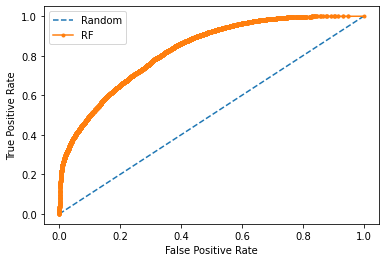

RF : Log Loss=0.593


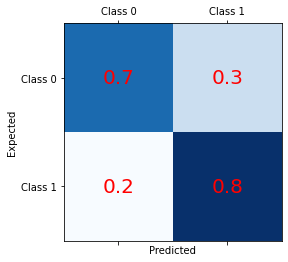

 Validation Performance 
Random: ROC AUC=0.500
RF : ROC AUC=0.629


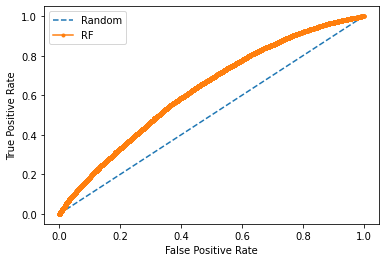

RF : Log Loss=0.652


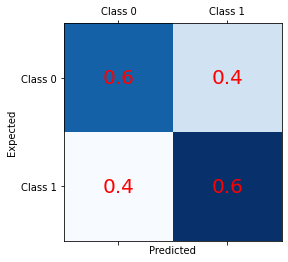

In [ ]:
model_rf_2 = RF(X_train, y_train, X_validate, y_validate, estimators=100, features=0.1, depth=12, oob_score_=True)

# Training a Logistic Regression model

The Logistic Regression model performs almost as good as the RF with ROC of 0.643

R^2 Training Score: 0.58 
R^2 Validation Score: 0.58
 Validation Performance 
Random: ROC AUC=0.500
Logistic Regression : ROC AUC=0.643


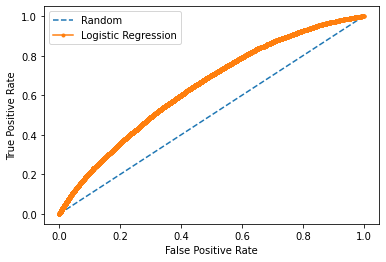

Logistic Regression : Log Loss=0.658


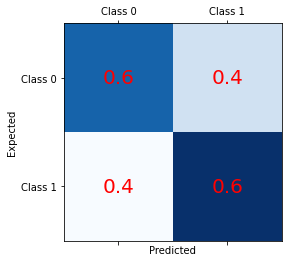

In [ ]:
model_lr_1 = lr(X_train, y_train, X_validate, y_validate)

But still the performance is poor given the importance of the accuracy of the label. I will try to train a MLP with a Binary Cross Entropy loss function

# MLP

##Preparing the data

In [ ]:
X_train, y_train, X_validate, y_validate = return_numpy(X_train, y_train, X_validate, y_validate)

## Building the network

In [ ]:
model_mlp_1 = MLP(D_in=X_train.shape[1], H=300, D_out=1)
model_mlp_1.apply(weights_init_normal)

if torch.cuda.is_available():
    print('CUDA Available')
    model_mlp_1.cuda()

## Training the model

Epoch [1/200] Train Loss: 0.6996, Valid Loss: 0.6806
Epoch [11/200] Train Loss: 0.6672, Valid Loss: 0.7313
Epoch [21/200] Train Loss: 0.6624, Valid Loss: 0.6801
Epoch [31/200] Train Loss: 0.6602, Valid Loss: 0.6859
Epoch [41/200] Train Loss: 0.6528, Valid Loss: 0.6613
Epoch [51/200] Train Loss: 0.6474, Valid Loss: 0.7183
Epoch [61/200] Train Loss: 0.6410, Valid Loss: 0.8801
Epoch [71/200] Train Loss: 0.6329, Valid Loss: 0.7854
Epoch [81/200] Train Loss: 0.6281, Valid Loss: 0.6176
Epoch [91/200] Train Loss: 0.6204, Valid Loss: 0.8020
Epoch [101/200] Train Loss: 0.6112, Valid Loss: 0.7193
Epoch [111/200] Train Loss: 0.6058, Valid Loss: 0.7762
Epoch [121/200] Train Loss: 0.5998, Valid Loss: 0.6885
Epoch [131/200] Train Loss: 0.5921, Valid Loss: 0.8765
Epoch [141/200] Train Loss: 0.5867, Valid Loss: 0.8998
Epoch [151/200] Train Loss: 0.5795, Valid Loss: 0.7433
Epoch [161/200] Train Loss: 0.5768, Valid Loss: 0.8065
Epoch [171/200] Train Loss: 0.5691, Valid Loss: 0.7434
Epoch [181/200] Train

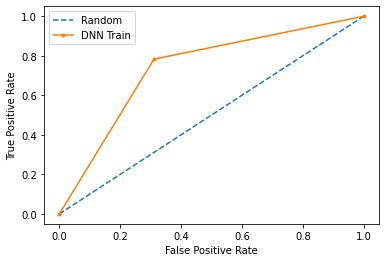

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:2295: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:2295: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)


DNN Train : Log Loss=nan


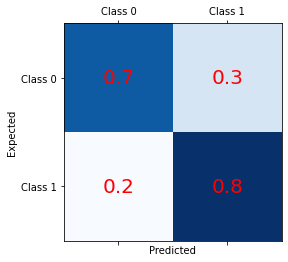

 Validation Performance 
Random: ROC AUC=0.500
DNN Validate : ROC AUC=0.539


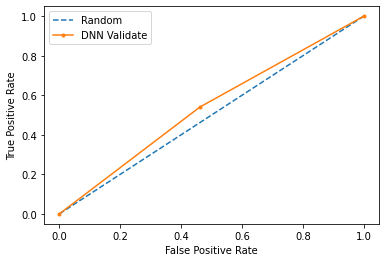

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:2295: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:2295: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)


DNN Validate : Log Loss=nan


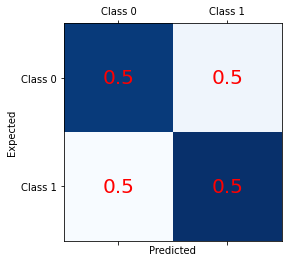

In [ ]:
# Trainning the model
model_mlp_1 = train_mlp(X_train=X_train, y_train=y_train, X_validate=X_validate, y_validate=y_validate, model=model_mlp_1, num_epochs=200, lr_=1e-3)

It is clear that the network in not learning much (underfitting). I tried to reduce the number of hidden layers, reduce the learning rate, but that didn't change much. Maybe the features that I am using are not that representative of the install probability.

# Other approach for feature selection

After testing the validation performance of the above approach (i.e. filtering many features before the training), I think that maybe one of the reasons the performance is poor is that all categorical features were omitted after the feature selection process. 

In this section, I will try to deal with some categorical features differently, by including some of them and one-hot-encode them afterwards in the dataset.

In [ ]:
data_df = pd.read_pickle("data_df_original")
numeric_features = data_df.select_dtypes(include=[np.number])

## Encoding all categorical features





Let us see how many unique value per categorical feature

In [ ]:
for column_name in data_df.columns:
    if data_df[column_name].dtypes == 'object':
      unique_category = len(data_df[column_name].unique())
      print("Feature '{column_name}' has '{unique_category}' unique categories".format(column_name = column_name,
                                                                                      unique_category=unique_category))

Feature 'id' has '2206990' unique categories
Feature 'campaignId' has '5704' unique categories
Feature 'platform' has '2' unique categories
Feature 'softwareVersion' has '174' unique categories
Feature 'country' has '221' unique categories
Feature 'connectionType' has '3' unique categories
Feature 'deviceType' has '23637' unique categories


Check visualy the relationship between **platform** and **connectionType** vs **install**

Text(0, 0.5, 'Frequency of Install')

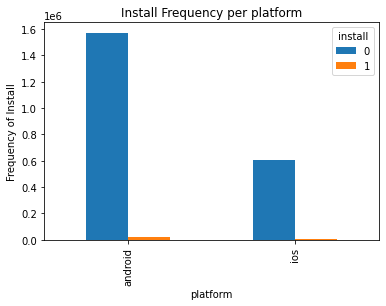

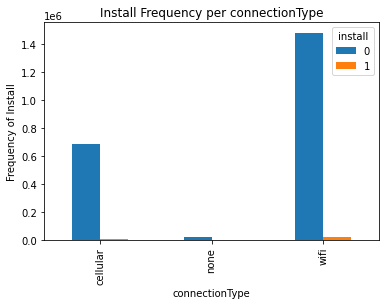

In [ ]:
%matplotlib inline

pd.crosstab(data_df.platform,data_df.install).plot(kind='bar')
plt.title('Install Frequency per platform')
plt.xlabel('platform')
plt.ylabel('Frequency of Install')

pd.crosstab(data_df.connectionType,data_df.install).plot(kind='bar')
plt.title('Install Frequency per connectionType')
plt.xlabel('connectionType')
plt.ylabel('Frequency of Install')

It seems that the frequency of install depends on the platform and connectionType. Thus, these can be good predictors of the outcome variable.

## One-Hot-Encoding for connectionType, platform, and "country" features

I will reduce the number of unique countries by replacing low frequency countries with the value Other. I cannot deal with categorical features with many unique values, otherwise I will run out of memory when I will one-hot-encode them.

In [ ]:
data_df = regroup_infrequent_countries(data_df)

Nb countries before the filtering: 221
Nb countries after the filtering: 23


Same for deviceType, but first I will regroup some similar deviceTypes:

In [ ]:
data_df = regroup_devices(data_df)

Nb deviceType before the filtering: 15162
Nb deviceType after the filtering: 13


In [ ]:
data_ohe = data_df[["connectionType", "platform", "country", "deviceType"]]
data_df.drop(columns=["connectionType", "platform", "country", "deviceType"], inplace=True)
data_ohe, oh_enc = one_hot_encode(data_ohe)
data_df = data_df.join(data_ohe)

Dropping Impression ID. It a unique ID that doesn't give any useful information for prediction

In [ ]:
data_df.drop(columns=["id"], inplace=True)

## Split

In [ ]:
train_df, validate_df = split_train_test(data_df)

Class 0: 98.8 % of the dataset
Class 1: 1.2 % of the dataset
Class 0: 98.79 % of the dataset
Class 1: 1.21 % of the dataset


##Remove Outliers

In [ ]:
IQR, Q1, Q3 = computer_IQR(train_df, cats=numeric_features.drop(columns=["sourceGameId", "install"]))

Lower Outliers
startCount             0
viewCount              0
clickCount             0
installCount           0
startCount1d           0
startCount7d           0
Event_Day              0
Event_Hour             0
Event_Minute           0
Event_Dayofweek        0
LastStart_Day          0
LastStart_Hour         0
LastStart_Minute       0
LastStart_Dayofweek    0
dtype: int64 

Upper Outliers
startCount             146192
viewCount              170252
clickCount             139220
installCount            94716
startCount1d           121050
startCount7d           126778
Event_Day                   0
Event_Hour                  0
Event_Minute                0
Event_Dayofweek             0
LastStart_Day            6742
LastStart_Hour              0
LastStart_Minute            0
LastStart_Dayofweek         0
dtype: int64 



In [ ]:
train_df = remove_outlier(train_df, IQR, Q1, Q3, cats=numeric_features.drop(columns=["sourceGameId", "install"]))

0    98.802245
1     1.197755
Name: install, dtype: float64
0    98.731042
1     1.268958
Name: install, dtype: float64


Given the feature selection approach I applied at the begining of the notebook, sourceGameID had a very low score (11.0218). However, it seems to me that the game that is being adverstised could have an influence on whether the user will install it or not. I am trying here to include this feature, but as a numerical feature. The draw back is that te ID order will be taking into account, cause it is delt with as a number, the model could think that a higher id number is more important than a lower id number, which normally should not be the case. Ideally, unique values of game ID should be encoded in a sort of embedding and used afterwards for training. This is a task that I would highly consider in a future work.

In [ ]:
train_df["sourceGameId"].value_counts()

1711292    24407
19790      13154
1483109    12873
111890     12063
19186      11841
           ...  
1748564        1
1801838        1
1167160        1
1535980        1
2801828        1
Name: sourceGameId, Length: 24820, dtype: int64

In [ ]:
Q1 = train_df["sourceGameId"].quantile(0.25)
Q3 = train_df["sourceGameId"].quantile(0.75)
IQR = Q3 - Q1
train_df[~(train_df["sourceGameId"] > (Q3 + 1.5 * IQR))].any(axis=1)

print(train_df.install.value_counts()/train_df.shape[0] * 100)
train_df = train_df[train_df.sourceGameId <= (Q3 + 1.5 * IQR)]
print(train_df.install.value_counts()/train_df.shape[0] * 100)

0    98.731042
1     1.268958
Name: install, dtype: float64
0    98.727435
1     1.272565
Name: install, dtype: float64


## Scale

I choose here to drop campaignId because its feature importance score is low (7.0673). Same for softwareVersion (9.3866)

In [ ]:
train_df.drop(columns=["campaignId","softwareVersion"], inplace=True)
validate_df.drop(columns=["campaignId","softwareVersion"], inplace=True)

In [ ]:
train_df, validate_df, min_max_scaler_2 = scale_dataset(train_df, validate_df)

##Listing of the 6 more useful numerical features

I will take into account the most 6 important numerical features based on the Anova score

In [ ]:
numeric_features = train_df.select_dtypes(include=[np.number])
train_df, validate_df = select_k_best_numeric_features(train_df, validate_df, numeric_features, 6)

F_classif selected 6 features ['sourceGameId', 'startCount', 'viewCount', 'installCount', 'startCount1d', 'startCount7d'].


## Correlation matrices to understand relationship between diff features that influence heavily in whether an install is observed


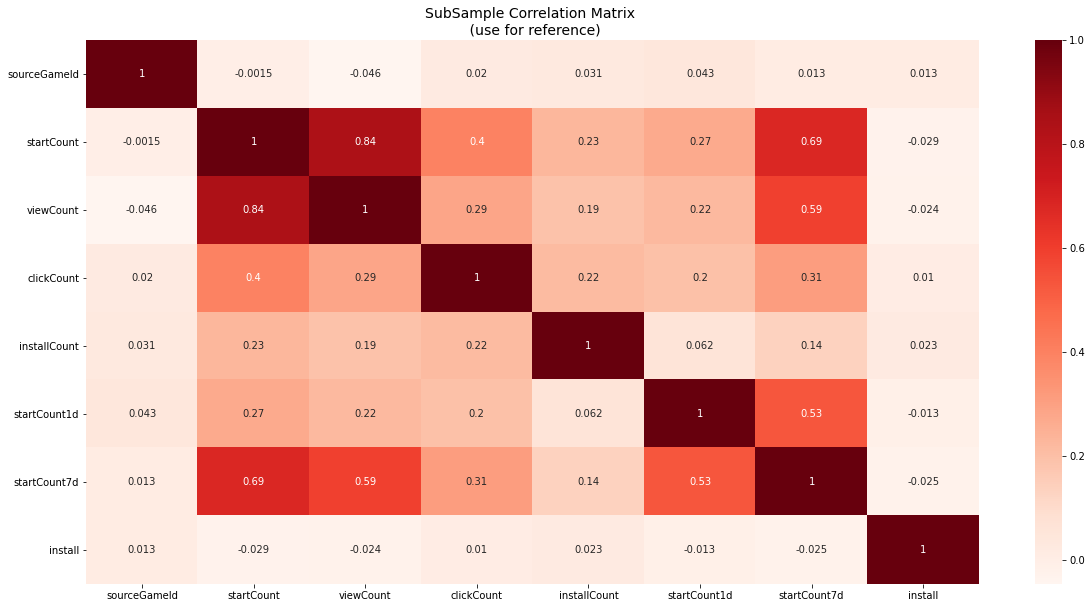

In [ ]:
numeric_features = ['sourceGameId', 'startCount', 'viewCount', 'clickCount', 'installCount', 'startCount1d', 'startCount7d', 'install']
train_df[numeric_features]

f, ax = plt.subplots(1, 1, figsize=(20,10))
sub_sample_corr = train_df[numeric_features].corr()
sns.heatmap(sub_sample_corr, cmap=plt.cm.Reds, annot=True, ax=ax)
ax.set_title('SubSample Correlation Matrix \n (use for reference)', fontsize=14)
plt.show()

The correlation matrix doesn't say much about the correlation between the install label and the other features, because install is binary. However, we can see that there is lots of correlation between **startCount**, **viewCount** and **startCount7d**, which makes me think to keep only one of them, because apparently they are dependent features. This is illustrated as well in the plot below, their distributions look very similar.

## Numerical features distribution for both classes (0 and 1 respectively) after some data cleaning (Outier removal and Scaling)

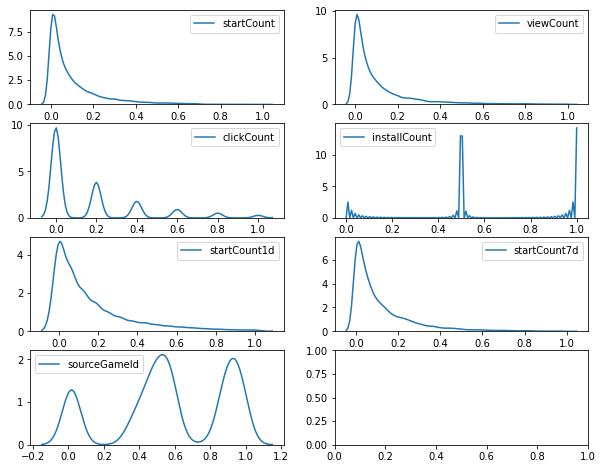

In [ ]:
# plot original distribution plot
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(ncols=2, nrows=4, figsize=(10, 8))
sns.kdeplot(train_df["startCount"].loc[train_df['install'] == 1], ax=ax1)
sns.kdeplot(train_df["viewCount"].loc[train_df['install'] == 1], ax=ax2)
sns.kdeplot(train_df["clickCount"].loc[train_df['install'] == 1], ax=ax3)
sns.kdeplot(train_df["installCount"].loc[train_df['install'] == 1], ax=ax4)
sns.kdeplot(train_df["startCount1d"].loc[train_df['install'] == 1], ax=ax5)
sns.kdeplot(train_df["startCount7d"].loc[train_df['install'] == 1], ax=ax6)
sns.kdeplot(train_df["sourceGameId"].loc[train_df['install'] == 1], ax=ax7)

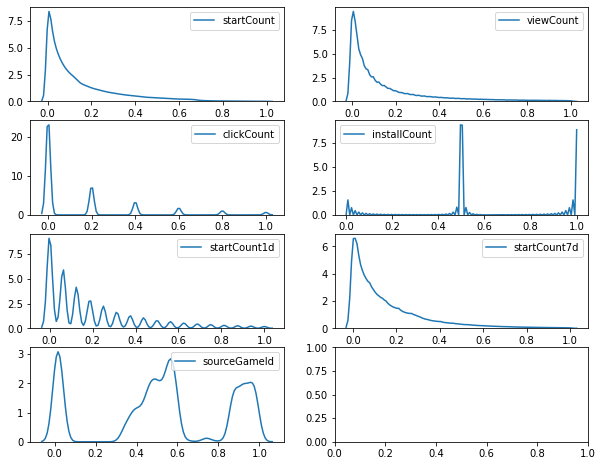

In [ ]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(ncols=2, nrows=4, figsize=(10, 8))
sns.kdeplot(train_df["startCount"].loc[train_df['install'] == 0], ax=ax1)
sns.kdeplot(train_df["viewCount"].loc[train_df['install'] == 0], ax=ax2)
sns.kdeplot(train_df["clickCount"].loc[train_df['install'] == 0], ax=ax3)
sns.kdeplot(train_df["installCount"].loc[train_df['install'] == 0], ax=ax4)
sns.kdeplot(train_df["startCount1d"].loc[train_df['install'] == 0], ax=ax5)
sns.kdeplot(train_df["startCount7d"].loc[train_df['install'] == 0], ax=ax6)
sns.kdeplot(train_df["sourceGameId"].loc[train_df['install'] == 0], ax=ax7)

## Feature Elimination

In [ ]:
# I will also drop clickCount, as it doesn't show in the best 6 numerical features

train_df.drop(columns=["viewCount", "startCount7d", "clickCount"], inplace=True)
validate_df.drop(columns=["viewCount", "startCount7d", "clickCount"], inplace=True)

## Resampling

Random Sampling:
1    13690
0    13690
Name: install, dtype: int64


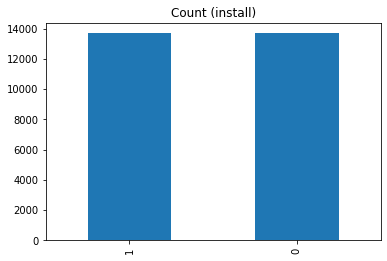

In [ ]:
train_df = resample_data(train_df)

In [ ]:
X_train, y_train, X_validate, y_validate = get_X_y_train_validate(train_df, validate_df)

## Training the Models

R^2 Training Score: 0.75 
R^2 Validation Score: 0.62
 Training Performance 
Random: ROC AUC=0.500
RF : ROC AUC=0.848


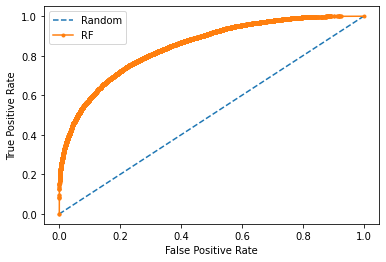

RF : Log Loss=0.583


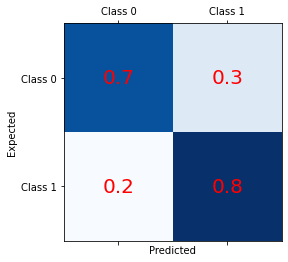

 Validation Performance 
Random: ROC AUC=0.500
RF : ROC AUC=0.652


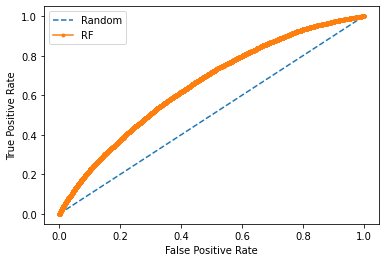

RF : Log Loss=0.629


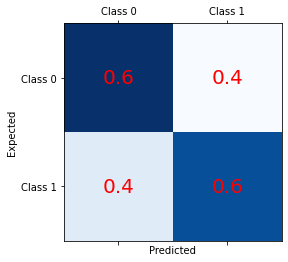

In [ ]:
model_rf_3 = RF(X_train, y_train, X_validate, y_validate, estimators=100, features=0.2, depth=12, oob_score_=True)

In [ ]:
pickle.dump(model_rf_3, open("model_rf_3", 'wb'))

The ROC of the RF with the new approach is better than the one before (0.65 vs 0.62), but still the ratio of FP and FN is the same as illustrated in the confusion matrix.

R^2 Training Score: 0.60 
R^2 Validation Score: 0.61
 Validation Performance 
Random: ROC AUC=0.500
Logistic Regression : ROC AUC=0.650


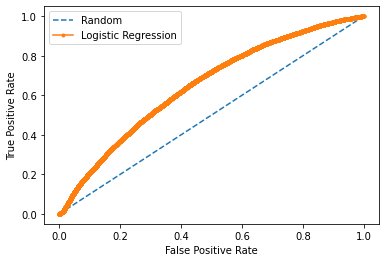

Logistic Regression : Log Loss=0.794


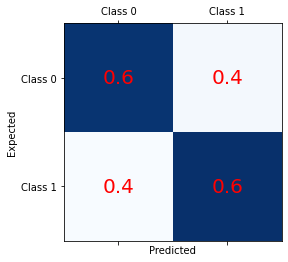

In [ ]:
model_lr_2 = lr(X_train, y_train, X_validate, y_validate)

In [ ]:
X_train, y_train, X_validate, y_validate = return_numpy(X_train, y_train, X_validate, y_validate)

In [ ]:
model_mlp_2 = MLP(D_in=X_train.shape[1], H=300, D_out=1)
model_mlp_2.apply(weights_init_normal)

if torch.cuda.is_available():
    print('CUDA Available')
    model_mlp_2.cuda()

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_mlp_2.parameters(), lr=1e-4)

Epoch [1/100] Train Loss: 0.7080, Valid Loss: 1.8716
Epoch [11/100] Train Loss: 0.6415, Valid Loss: 1.7125
Epoch [21/100] Train Loss: 0.5753, Valid Loss: 1.8152
Epoch [31/100] Train Loss: 0.4648, Valid Loss: 2.1232
Epoch [41/100] Train Loss: 0.3761, Valid Loss: 3.0639
Epoch [51/100] Train Loss: 0.3188, Valid Loss: 4.4981
Epoch [61/100] Train Loss: 0.2910, Valid Loss: 4.4153
Epoch [71/100] Train Loss: 0.2582, Valid Loss: 4.7620
Epoch [81/100] Train Loss: 0.2383, Valid Loss: 4.3065
Epoch [91/100] Train Loss: 0.2343, Valid Loss: 4.4373
Accuracy on training set is 0.9537253469685902
ROC AUC on training set is 0.9537253469685902
 Training Performance 
Random: ROC AUC=0.500
DNN Train : ROC AUC=0.954


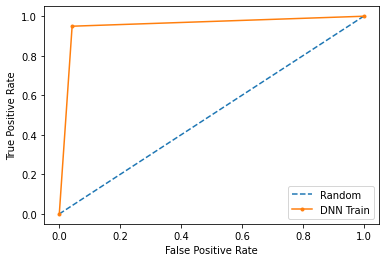

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:2295: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:2295: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)


DNN Train : Log Loss=nan


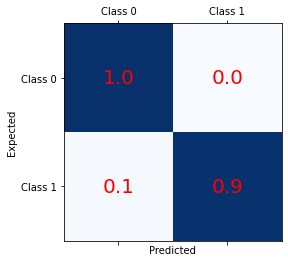

 Validation Performance 
Random: ROC AUC=0.500
DNN Validate : ROC AUC=0.556


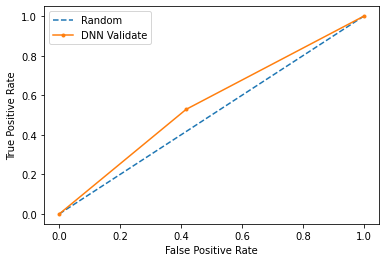

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:2295: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:2295: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)


DNN Validate : Log Loss=nan


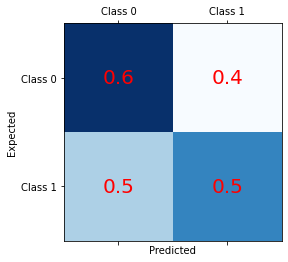

In [ ]:
# Trainning the model
model_mlp_2 = train_mlp(X_train=X_train, y_train=y_train, X_validate=X_validate, y_validate=y_validate, model=model_mlp_2, num_epochs=100, lr_=0.01)

The Neural Network learns better here as shown by the ROC for the training dataset, but still overfits, as the ROC of validation is close to random.

It was challenging to improve the ROC better than 0.65. The model that performes best was model_lr_2. Therefor, it is the one that I will use to evaluate the test data set as shown below.

#Test set evaluation

In [ ]:
import csv
test_df = pd.read_csv('test_data.csv', sep=';', quoting=3, error_bad_lines=False)

# Cause there are two missing values in deviceType
test_df = test_df.fillna(-1)

In [ ]:
# Handling datetime feature
test_df["timestamp_dt"] = pd.to_datetime(test_df["timestamp"], format = "%Y-%m-%dT%H:%M:%S", errors = "coerce")
test_df["lastStart_dt"] = pd.to_datetime(test_df["lastStart"], format = "%Y-%m-%dT%H:%M:%S", errors = "coerce")

test_df.drop(columns=["timestamp", "lastStart"], inplace=True)

test_df["Event_Year"] = test_df["timestamp_dt"].dt.year
test_df["Event_Month"] = test_df["timestamp_dt"].dt.month
test_df["Event_Day"] = test_df["timestamp_dt"].dt.day
test_df["Event_Hour"] = test_df["timestamp_dt"].dt.hour
test_df["Event_Minute"] = test_df["timestamp_dt"].dt.minute
test_df["Event_Dayofweek"] = test_df["timestamp_dt"].dt.dayofweek

test_df["LastStart_Year"] = test_df["lastStart_dt"].dt.year
test_df["LastStart_Month"] = test_df["lastStart_dt"].dt.month
test_df["LastStart_Day"] = test_df["lastStart_dt"].dt.day
test_df["LastStart_Hour"] = test_df["lastStart_dt"].dt.hour
test_df["LastStart_Minute"] = test_df["lastStart_dt"].dt.minute
test_df["LastStart_Dayofweek"] = test_df["lastStart_dt"].dt.dayofweek

test_df.drop(columns=["timestamp_dt", "lastStart_dt"], inplace=True)

test_df.drop(columns=["Event_Year", "Event_Month"], inplace=True)
test_df.drop(columns=["LastStart_Year", "LastStart_Month"], inplace=True)

test_df['LastStart_Day'].fillna(test_df['LastStart_Day'].min(), inplace=True)
test_df['LastStart_Dayofweek'].fillna(test_df['LastStart_Dayofweek'].min(), inplace=True)
test_df['LastStart_Hour'].fillna(test_df['LastStart_Hour'].min(), inplace=True)
test_df['LastStart_Minute'].fillna(test_df['LastStart_Minute'].min(), inplace=True)

test_df['country'].fillna("Other", inplace=True)

In [ ]:
# One Hot Encoding
data_ohe = test_df[["connectionType", "platform", "country", "deviceType"]]
test_df.drop(columns=["connectionType", "platform", "country", "deviceType"], inplace=True)
transformed = oh_enc.transform(data_ohe).toarray()
transformed = pd.DataFrame(transformed)
test_df = test_df.join(transformed)

In [ ]:
test_id = test_df["id"]
test_df.drop(columns=["campaignId","softwareVersion", "id"], inplace=True)

In [ ]:
# Scale features
cols = test_df.columns
test_df = min_max_scaler_2.transform(test_df)
test_df = pd.DataFrame(test_df, columns=cols)

In [ ]:
# Feature Elimination
test_df.drop(columns=["viewCount", "startCount7d", "clickCount"], inplace=True)

In [ ]:
# saving test data after manipulations
test_df.to_pickle("test_df_ready")

In [ ]:
# load RF trained model
loaded_model = pickle.load(open("model_rf_3", 'rb'))

In [ ]:
# Do the prediction
y_pred = loaded_model.predict(test_df)

In [ ]:
# save into csv
test = pd.DataFrame(test_id, columns=["ID"]).reset_index(drop=True)
y = pd.DataFrame(y_pred, columns=["install_proba"]).reset_index(drop=True)
test = pd.concat([test_id, y], axis=1)
test.to_csv("output.csv")

# Future Work

I have many things in mind to try to improve the prediction performance.

1.   We need to collect more data to class (install = 1)
2.   Understand from an expert the most important features that can be more representative
3.   Use embeddings like in word embeddings, to encode the information of the categorical features, instead of the one-hot-encoding. That will permet us to use more categorical features, like **campaignId** and **softwareVersion** that could help the models. We could also skip the part where I regroup unfrequent Countries and deviceTypes, whoch could help as well to improve the performance
4.   Try to use regularization techniques (dropout or L2 Norm) for the MLP to reduce the overfitting in the second approach.
5.   Do more hyperparameter search for RF, trying to reduce overfitting.
